# Sign Language Classfication: Use VGG model





> Instroduction: Use dataset: ASL dataset & MNIST dataset

```
ASL: 29 classes(A-Z, space, delete, nothing), 87000 images(200x200)
(source: https://www.kaggle.com/datasets/grassknoted/asl-alphabet)

```

```
MNIST: 24 classes(A-Z, excluding j=9 and z= 25), train: 27455 images (28x28), test: 7172 images(28x28)
(source: https://www.kaggle.com/datasets/datamunge/sign-language-mnist?resource=download-directory)

```





Use Model: VGG models



## Import Library and use GPU

In [217]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [262]:
import cv2
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Dataset
from google.colab import drive
torch.manual_seed(777)
drive.mount('/content/drive')

if torch.cuda.is_available():
   device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

# def to_device(data, device):
#     if isinstance(data, (list, tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


## ASL

### Data Load and Preprocess

In [ ]:
# test#1 fail
# class ASLDataset(Dataset):
#     def __init__(self, path):
#         classes = os.listdir(path)
#         classes.sort(reverse=False)
#         cmap = {v:i for i, v in enumerate(classes)}
#         self.X = []
#         for label in classes:
#             for data in os.listdir(path+'/'+label):
#                 image = cv2.imread(path+'/'+label+'/'+data)/255
#                 image = cv2.resize(image, (128, 128))
#                 image = np.transpose(image, axes=(2,0,1))
#                 image = torch.from_numpy(image)
#                 self.X.append([image, cmap[label]])
#         self.y = tuple(cmap.valuese())

#     def __len__(self):
#         return len(self.X)
        
#     def __getitem__(self, idx):
#         X, y = self.X[idx], self.y[idx]
#         return X, torch.Tensor(y)

# test#2 
class ASLDataset(Dataset):
    def __init__(self, path):
        self.path = path
        classes = os.listdir(self.path)
        classes.sort(reverse=False)
        cmap = {v:i for i, v in enumerate(classes)}
        self.X = []
        self.y = []
        for label in tqdm(classes):
            for data in os.listdir(self.path+'/'+label):
                x = cv2.imread(self.path+'/'+label+'/'+data).astype(np.uint8)
                x = cv2.resize(x, (64, 64)).transpose((2, 0, 1))
                self.X.append(x)
                del x 
                self.y.append(cmap[label])
        del cmap, classes

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx])/255
        #X = tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(X)
        y = self.y[idx]
        return X, y

In [ ]:
!ls
os.chdir('/content/drive/MyDrive/Colab Notebooks/dataset')
!ls

asl_path = './ASL dataset/ASL_alphabet/asl_alphabet_train'
asl_class = os.listdir(asl_path)

# transform = tt.Compose(
#     [
#         tt.Resize(128),
#         tt.ToTensor(),
#         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ]
# )

# asl_dataset = ImageFolder(asl_path, transform)
asl_dataset = ASLDataset(asl_path)
img, label = asl_dataset[3000]
print(asl_dataset[0], img.shape)

val_size = 7000    
test_size = 14000   
train_size = len(asl_dataset) - val_size - test_size
asl_train, asl_val, asl_test = random_split(asl_dataset, [train_size, val_size, test_size])
print(len(asl_train), len(asl_val), len(asl_test))

drive  sample_data
'ASL dataset'   asl_vgg19.pth   asl_weights.pth


100%|██████████| 29/29 [05:51<00:00, 12.12s/it]

(tensor([[[0.8980, 0.7137, 0.7098,  ..., 0.7098, 0.7216, 0.8314],
         [0.7137, 0.3020, 0.2980,  ..., 0.1843, 0.4000, 0.6549],
         [0.7216, 0.2863, 0.2392,  ..., 0.3765, 0.3961, 0.6902],
         ...,
         [0.7686, 0.8392, 0.8667,  ..., 0.6431, 0.6588, 0.9843],
         [0.7843, 0.9020, 0.8863,  ..., 0.6431, 0.6549, 0.9804],
         [0.8471, 0.9922, 0.9961,  ..., 0.9373, 0.9686, 1.0000]],

        [[0.0039, 0.0510, 0.0510,  ..., 0.0431, 0.0392, 0.0275],
         [0.0549, 0.4275, 0.4549,  ..., 0.2392, 0.4118, 0.3804],
         [0.0588, 0.4275, 0.3882,  ..., 0.4118, 0.3843, 0.3608],
         ...,
         [0.0980, 0.8667, 0.8863,  ..., 0.6627, 0.6824, 0.6510],
         [0.0863, 0.8941, 0.8863,  ..., 0.6510, 0.6745, 0.6549],
         [0.0706, 0.8471, 0.8549,  ..., 0.6078, 0.6353, 0.6118]],

        [[0.0118, 0.0510, 0.0667,  ..., 0.0471, 0.0588, 0.0510],
         [0.0706, 0.5412, 0.5294,  ..., 0.3255, 0.4745, 0.3882],
         [0.0863, 0.5020, 0.4431,  ..., 0.4745, 0.4471, 0

In [ ]:
batch_size = 256
asl_train_dl = DataLoader(asl_train, batch_size, num_workers=2, shuffle=True)
asl_val_dl = DataLoader(asl_val, batch_size, shuffle=True)
asl_test_dl = DataLoader(asl_val, batch_size)
print(type(asl_train))
print(type(asl_train_dl))
print(asl_train_dl.batch_size)
# images, labels = next(iter(asl_train_dl))

# from torchvision.utils import make_grid
# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(32, 8))
#         ax.set_xticks([]) ; ax.set_yticks([])
#         ax.imshow(make_grid(images.to('cpu'), nrow=32).permute(1, 2, 0))
#         break

# show_batch(asl_train_dl)

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataloader.DataLoader'>
256


### Make Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channel, out_channel, pool=False):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1), nn.ReLU(True)]
    if pool:
        layers.append(nn.MaxPool2d(2,2))
    return nn.Sequential(*layers)

class ImageClassfication(nn.Module):
    def train_step(self, batch):
        images, classes = batch
        out = self(images)          #Generate prediction
        loss = F.cross_entropy(out, classes)   #Calculate loss
        return loss

    def validation_step(self, batch):
        images, classes = batch
        out = self(images)                  
        loss = F.cross_entropy(out, classes)
        acc = accuracy(out, classes)            #Calculate Accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class VGG16(ImageClassfication):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64, True),   #64x64x64

            conv_block(64, 128),
            conv_block(128, 128, True), #128x32x32

            conv_block(128, 256),
            conv_block(256, 256),
            conv_block(256, 256, True), #256x16x16

            conv_block(256, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x8x8

            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x4x4

            #classifier
            nn.Sequential(
                nn.Flatten(), 
                nn.Linear(512 * 2 * 2, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, num_classes)
            )
         )
    def forward(self, xb):
         return self.network(xb)

class VGG19(ImageClassfication):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64, True),   #64x64x64

            conv_block(64, 128),
            conv_block(128, 128, True), #128x32x32

            conv_block(128, 256),
            conv_block(256, 256),
            conv_block(256, 256),
            conv_block(256, 256, True), #256x16x16

            conv_block(256, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x8x8

            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x4x4

            #classifier
            nn.Sequential(
                nn.Flatten(), 
                nn.Linear(512 * 2 * 2, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, num_classes)
                )
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, xb):
         return self.network(xb)

# model1 = VGG16(29)
# for images, classes in asl_train_dl:
#      print('image.shpae:', images.shape)
#      out = model2(images)
#      print(out)
#      print(out[0].sum())
#      print('out.shape:', out.shape)
#      break

### Training

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, lr, model, train_loader, val_loader,load=False,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    if load:
        checkpoint = torch.load('./asl_weights.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        count = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        #Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './asl_weights.pth')
    
    del loss, result, train_losses
    torch.cuda.empty_cache()
    return history


In [ ]:
lr = 0.01
epochs = 10

model2 = VGG19(29)
model2.to(device)
asl_train_dl = DeviceDataLoader(asl_train_dl, device)
asl_val_dl = DeviceDataLoader(asl_val_dl, device)
asl_test_dl = DeviceDataLoader(asl_test_dl, device)

VGG19_history = training(epochs, lr, model2, asl_train_dl, asl_val_dl, load=False)

#VGG16_history = training(epochs, lr, model1, asl_train_dl, asl_val_dl)

# function ClickConnect(){
#     console.log("코랩 연결 끊김 방지"); 
#     document.querySelector("colab-toolbar-button#connect").click() 
# }
# setInterval(ClickConnect, 60 * 1000)

100%|██████████| 258/258 [01:29<00:00,  2.89it/s]


Epoch [0], val_loss: 3.3675, val_acc: 0.0304


100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


Epoch [1], val_loss: 3.3673, val_acc: 0.0315


100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


Epoch [2], val_loss: 3.3392, val_acc: 0.0482


100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


Epoch [3], val_loss: 1.5976, val_acc: 0.4462


100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


Epoch [4], val_loss: 0.2959, val_acc: 0.9032


100%|██████████| 258/258 [01:34<00:00,  2.72it/s]


Epoch [5], val_loss: 0.0968, val_acc: 0.9632


100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


Epoch [6], val_loss: 0.0975, val_acc: 0.9656


100%|██████████| 258/258 [01:34<00:00,  2.72it/s]


Epoch [7], val_loss: 0.0401, val_acc: 0.9872


100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


Epoch [8], val_loss: 0.0415, val_acc: 0.9851


100%|██████████| 258/258 [01:34<00:00,  2.73it/s]


Epoch [9], val_loss: 0.0133, val_acc: 0.9958


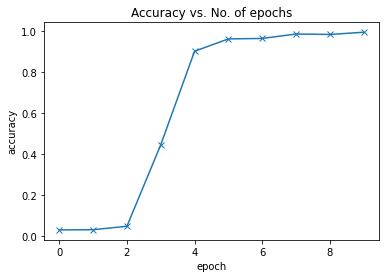

In [ ]:
acc = [x['val_acc'] for x in VGG19_history]
plt.plot(acc, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

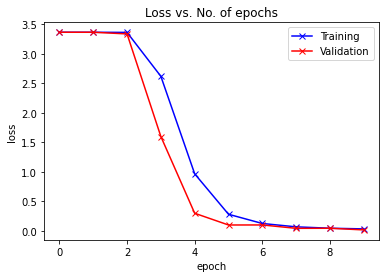

In [ ]:
train_loss = [x['train_loss'] for x in VGG19_history]
val_loss = [x['val_loss'] for x in VGG19_history]
plt.plot(train_loss, '-bx')
plt.plot(val_loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

In [ ]:
torch.save(model2,'./asl_vgg19.pth')

### Test

In [ ]:
test_model = torch.load('./asl_vgg19.pth')
test_model.to(device)

yes = 0
no = 0
for images, labels in tqdm(asl_test_dl):
    out = test_model(images)
    _, pred = torch.max(out, dim=1)
    for i in range(len(pred)):
        if  pred[i] == labels[i]:
            yes = yes + 1
        else:
            no = no +1

total = yes + no
correct_percent = yes/total * 100
print("\ntesting result:", correct_percent, "%")

100%|██████████| 28/28 [00:03<00:00,  7.52it/s]


testing result: 99.6 %


## MNIST

### Data Load and Preprocess

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, path):
        self.X = pd.read_csv(path)
        self.y = self.X['label'].values
        self.X.drop('label', axis=1, inplace=True)
        self.X = torch.FloatTensor(pd.DataFrame.to_numpy(self.X))
        self.X = self.X.reshape(self.X.size(dim=0), 28, 28)/255
        self.X = torch.stack([self.X, self.X, self.X]).permute(1,0,2,3)

    def __len__(self):
        return self.X.size(dim=0)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        return X, y


'ASL dataset'   asl_vgg19.pth   asl_weights.pth   mnist_vgg19.pth
'ASL dataset'   asl_vgg19.pth   asl_weights.pth   mnist_vgg19.pth
tensor([[[0.4196, 0.4627, 0.4980,  ..., 0.6667, 0.6667, 0.6627],
         [0.4353, 0.4745, 0.5059,  ..., 0.6706, 0.6706, 0.6667],
         [0.4431, 0.4824, 0.5137,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.5569, 0.5882, 0.6235,  ..., 0.7922, 0.7882, 0.7843],
         [0.5569, 0.5922, 0.6275,  ..., 0.8000, 0.7961, 0.7922],
         [0.5569, 0.5922, 0.6275,  ..., 0.8000, 0.7961, 0.7922]],

        [[0.4196, 0.4627, 0.4980,  ..., 0.6667, 0.6667, 0.6627],
         [0.4353, 0.4745, 0.5059,  ..., 0.6706, 0.6706, 0.6667],
         [0.4431, 0.4824, 0.5137,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.5569, 0.5882, 0.6235,  ..., 0.7922, 0.7882, 0.7843],
         [0.5569, 0.5922, 0.6275,  ..., 0.8000, 0.7961, 0.7922],
         [0.5569, 0.5922, 0.6275,  ..., 0.8000, 0.7961, 0.7922]],

        [[0.4196, 0.4627, 0.4980,  ..., 0.6667, 0.6667, 

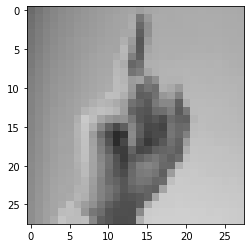

27455 7172
20000 7455 7172


In [ ]:
!ls
os.chdir('/content/drive/MyDrive/Colab Notebooks/dataset')
!ls

mnist_path = './ASL dataset/MNIST_sign/'
mnist_cmp = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
mnist_train = MNISTDataset(mnist_path+'sign_mnist_train/sign_mnist_train.csv')
mnist_test = MNISTDataset(mnist_path+'sign_mnist_test/sign_mnist_test.csv')

img, classes = mnist_train[0]
print(img.shape, classes)
plt.imshow(img.permute(1,2,0))
plt.show()


print(len(mnist_train), len(mnist_test))
val_size = 7455
train_size = len(mnist_train) - val_size

mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])
print(len(mnist_train), len(mnist_val), len(mnist_test))

<class 'torch.utils.data.dataloader.DataLoader'>
256
torch.Size([256, 3, 28, 28])
tensor([ 1, 17, 10,  4, 19, 22, 15, 10, 19, 23,  2,  5,  3, 11,  1,  3,  8, 19,
         3, 16, 17, 24, 19,  1, 10, 14, 24, 14,  5, 23, 24, 23,  6, 21,  4, 16,
         5,  5, 18, 10, 17, 19, 19, 12, 21, 10, 12, 14, 11, 19,  5, 20, 21,  4,
        13, 14, 13, 21,  6,  8,  6, 19,  8, 17, 13, 20, 14, 24, 10, 20, 11, 19,
        23, 20,  5, 16,  8,  4, 22, 19,  4, 14, 23, 17,  8,  5,  0,  3,  8, 16,
        24,  7,  7,  3, 12, 24, 16, 17, 13,  8, 10, 21, 10,  1, 15,  6, 13, 19,
        15, 11,  6,  5, 24, 21, 11,  8,  4, 15,  4, 12, 13, 20,  4,  5, 23,  0,
         6,  6, 13, 22,  8, 15, 13, 13, 18, 15,  3, 21, 19, 13,  3,  7, 15,  3,
        11,  4, 10, 23,  1, 15,  7,  7, 10,  6, 19,  7, 23,  7,  8,  0, 11, 14,
        20,  7,  5, 10, 11,  1, 14,  5,  1, 11, 21, 18,  6,  7, 23, 13,  0,  5,
         8,  4,  5, 10,  2, 16,  8, 16, 12, 18, 13, 12, 12, 13, 13, 21, 24,  6,
         2, 24,  5, 23, 17, 16, 14, 10

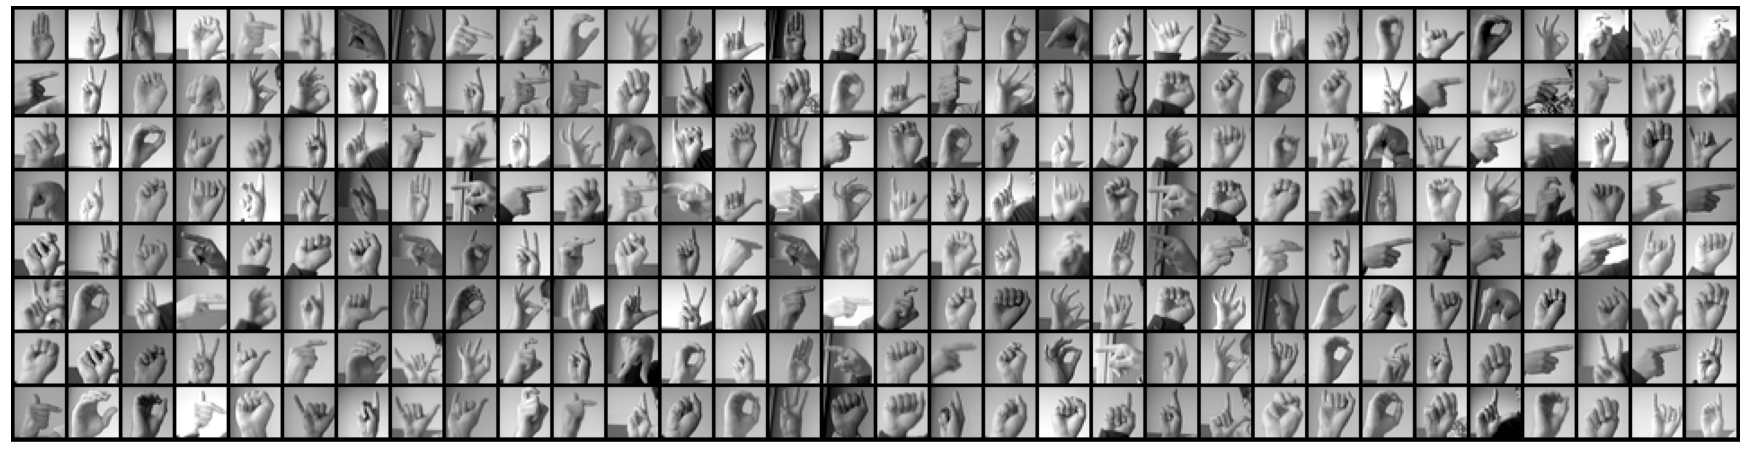

In [ ]:

pbatch_size = 256
mnist_train_dl = DataLoader(mnist_train, batch_size, shuffle=True)
mnist_val_dl = DataLoader(mnist_val, batch_size)
mnist_test_dl = DataLoader(mnist_test, batch_size)

print(type(mnist_train_dl))
print(mnist_train_dl.batch_size)

images, labels = next(iter(mnist_train_dl))
print(images.shape)
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(32, 8))
        ax.set_xticks([]) ; ax.set_yticks([])
        ax.imshow(make_grid(images.to('cpu'), nrow=32).permute(1, 2, 0))
        print(labels)
        break

show_batch(mnist_train_dl)

### Make Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channel, out_channel, pool=False):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1), nn.ReLU()]
    if pool:
        layers.append(nn.MaxPool2d(2,2))
    return nn.Sequential(*layers)

class ImageClassfication(nn.Module):
    def train_step(self, batch):
        images, classes = batch
        out = self(images)          #Generate prediction
        loss = F.cross_entropy(out, classes)   #Calculate loss
        return loss

    def validation_step(self, batch):
        images, classes = batch
        out = self(images)                  
        loss = F.cross_entropy(out, classes)
        acc = accuracy(out, classes)            #Calculate Accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class VGG19(ImageClassfication):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64),   #64x28x28

            conv_block(64, 128),
            conv_block(128, 128), #128x28x28

            conv_block(128, 256),
            conv_block(256, 256),
            conv_block(256, 256),
            conv_block(256, 256, True), #256x14x14

            conv_block(256, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512), #512x14x14

            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x7x7

            #classifier
            nn.Sequential(
                nn.Flatten(), 
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(4096, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, num_classes)
            )
         )
    def forward(self, xb):
         return self.network(xb)

# for images, classes in mnist_train_dl:
#      print('image.shpae:', images.shape)
#      out = model(images)
#      print('out.shape:', out.shape)
#      break

### Training

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, lr, model, train_loader, val_loader,load=False,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    if load:
        checkpoint = torch.load('./mnist_weights.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        count = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        #Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './mnist_weights.pth')
    
    del loss, result, train_losses
    torch.cuda.empty_cache()
    return history


In [ ]:
lr = 0.01
epochs = 10
model = VGG19(25)
model.to(device)
mnist_train_dl = DeviceDataLoader(mnist_train_dl, device)
mnist_val_dl = DeviceDataLoader(mnist_val_dl, device)
mnist_test_dl = DeviceDataLoader(mnist_test_dl, device)

VGG19_history = training(epochs, lr, model, mnist_train_dl, mnist_val_dl, load=False)

100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch [0], val_loss: 3.2068, val_acc: 0.0424


100%|██████████| 79/79 [01:15<00:00,  1.04it/s]


Epoch [1], val_loss: 3.1989, val_acc: 0.0459


100%|██████████| 79/79 [01:15<00:00,  1.05it/s]


Epoch [2], val_loss: 3.1939, val_acc: 0.0465


100%|██████████| 79/79 [01:15<00:00,  1.04it/s]


Epoch [3], val_loss: 3.1902, val_acc: 0.0465


100%|██████████| 79/79 [01:15<00:00,  1.05it/s]


Epoch [4], val_loss: 3.1874, val_acc: 0.0465


100%|██████████| 79/79 [01:15<00:00,  1.04it/s]


Epoch [5], val_loss: 3.1849, val_acc: 0.0465


 49%|████▉     | 39/79 [00:39<00:40,  1.00s/it]


KeyboardInterrupt: ignored

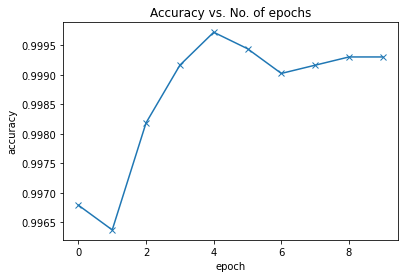

In [ ]:
acc = [x['val_acc'] for x in VGG19_history]
plt.plot(acc, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

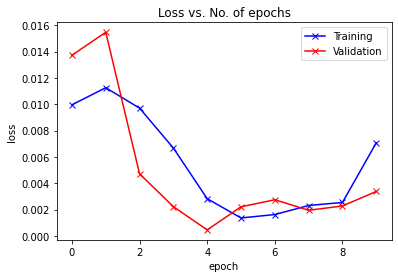

In [ ]:
train_loss = [x['train_loss'] for x in VGG19_history]
val_loss = [x['val_loss'] for x in VGG19_history]
plt.plot(train_loss, '-bx')
plt.plot(val_loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

In [ ]:
torch.save(model,'./mnist_vgg19.pth')

### Test

In [ ]:
test_model = torch.load('./mnist_vgg19.pth')
test_model.to(device)

yes = 0
no = 0
for images, labels in tqdm(mnist_test_dl):
    out = test_model(images)
    _, pred = torch.max(out, dim=1)
    for i in range(len(pred)):
        if  pred[i] == labels[i]:
            yes = yes + 1
        else:
            no = no +1

total = yes + no
correct_percent = yes/total * 100
print("\ntesting result:", correct_percent, "%")

100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


testing result: 5.186837702175126 %
